## Load Data

In [ ]:
import re
import warnings
from collections import Counter
from itertools import chain
from typing import List, Mapping, Tuple, Union

import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from scipy.sparse import csr_matrix
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.manifold import Isomap
from sklearn.preprocessing import normalize
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from nltk.corpus import stopwords
import pymorphy3
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
from umap import UMAP
from tqdm import tqdm
from openai import OpenAI

from bertopic import BERTopic
from bertopic.representation._base import BaseRepresentation

warnings.filterwarnings("ignore")

e:\PythonProjects\DynamicTopicModeling\.venv\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
df_docs = pd.read_csv('data_try.csv')
df_docs = df_docs.rename(columns={'Document': 'clean_text'})

## Модуль репрезентации

Два класса для репрезентации темы:
1) использует для получения ключевых слов Counter
2) использует для получения ключевых слов c_tf_idf распределение - рекомендуемый вариант

In [ ]:
class CustomRepresentationModel(BaseRepresentation):
    def __init__(self, stop_words: List[str]):
        self.stop_words = set(stop_words)
        self.morph = pymorphy3.MorphAnalyzer()
    
    def lemmatize(self, word: str) -> str:
        return self.morph.parse(word)[0].normal_form

    def preprocess(self, text: str) -> List[str]:
        words = re.findall(r'\b\w+\b', text.lower())
        words = [self.lemmatize(word) for word in words if word not in self.stop_words]
        return words
    
    def extract_topics(self, topic_model, documents, c_tf_idf, topics
                      ) -> Mapping[str, List[Tuple[str, float]]]:
        updated_topics = {}
        for topic, words in topics.items():
            processed_words = []
            for word, score in words:
                clean_word = self.lemmatize(word)
                if clean_word not in self.stop_words:
                    processed_words.append((clean_word, score))
            # Объединение одинаковых слов и их баллов
            word_counts = Counter()
            for word, score in processed_words:
                word_counts[word] += score
            updated_topics[topic] = word_counts.most_common()
        return updated_topics


e:\PythonProjects\DynamicTopicModeling\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class CustomCTFIDFRepresentation(BaseRepresentation):
    """
    Representation model that lemmatizes Russian text, removes stop-words,
    and ranks topic words by class-based TF-IDF (c-TF-IDF) extracted
    from the BERTopic model.
    """
    def __init__(self, stop_words: List[str]):
        self.stop_words = set(stop_words)
        self.morph = pymorphy3.MorphAnalyzer()

    def lemmatize(self, word: str) -> str:
        return self.morph.parse(word)[0].normal_form

    def preprocess(self, text: str) -> List[str]:
        tokens = re.findall(r'\b\w+\b', text.lower())
        return [
            self.lemmatize(tok)
            for tok in tokens
            if tok not in self.stop_words
        ]

    def extract_topics(
        self,
        topic_model,
        documents: List[str],
        c_tf_idf: csr_matrix,
        topics: Mapping[int, List[Tuple[str, float]]]
    ) -> Mapping[int, List[Tuple[str, float]]]:
        """
        Заменяем оригинальные скоринги на c-TF-IDF из c_tf_idf,
        корректно выровненные по строкам матрицы.
        """
        # Матрица c-TF-IDF имеет shape (n_topics_slice, n_terms)
        matrix = c_tf_idf

        # Словарь векторизатора
        vectorizer = topic_model.vectorizer_model
        if hasattr(vectorizer, "vocabulary_"):
            vocab = vectorizer.vocabulary_
        else:
            vocab = {term: idx for idx, term in enumerate(
                vectorizer.get_feature_names_out()
            )}

        # Построим маппинг Topic ID -> строка в матрице c_tf_idf
        topic_labels = list(topics.keys())
        topic_to_row = {t: i for i, t in enumerate(topic_labels)}

        updated_topics = {}
        for topic_id, word_list in topics.items():
            row_idx = topic_to_row[topic_id]
            scores: dict = {}
            for word, _ in word_list:
                lemma = self.lemmatize(word)
                if lemma in self.stop_words or lemma not in vocab:
                    continue
                col_idx = vocab[lemma]
                score = float(matrix[row_idx, col_idx])
                scores[lemma] = max(scores.get(lemma, 0.0), score)
            # сортируем по убыванию c-TF-IDF
            sorted_terms = sorted(
                scores.items(), key=lambda x: x[1], reverse=True
            )
            updated_topics[topic_id] = sorted_terms

        return updated_topics

In [4]:
stop_words = stopwords.words('russian')

add_stop_words = '''которых которые твой которой которого сих ком свой твоя этими слишком нами всему будь саму чаще ваше сами наш затем
еще самих наши ту каждое мочь весь этим наша своих оба который зато те этих вся ваш такая теми ею которая нередко
каждая также чему собой самими нем вами ими откуда такие тому та очень сама нему алло оно этому кому тобой таки твоё
каждые твои мой нею самим ваши ваша кем мои однако сразу свое ними всё неё тех хотя всем тобою тебе одной другие
этао само эта буду самой моё своей такое всею будут своего кого свои мог нам особенно её самому наше кроме вообще вон
мною никто это просто ещё почему это'''

add_stop_words = add_stop_words.split()
stop_words.extend(add_stop_words)

In [5]:
representation_model = CustomCTFIDFRepresentation(stop_words)

## Обучение

Здесь представлены разнообразные модели для BERTopic, в текущем пайплане используется stsb-xlm-r-multilingual + UMAP + HDBSCAN, последние 2 идут по умолчанию в BERTopic

In [8]:
model_paraphrase = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

In [6]:
model_stsb = SentenceTransformer('sentence-transformers/stsb-xlm-r-multilingual')

In [28]:
model_rubert = SentenceTransformer('cointegrated/rubert-tiny2')

In [37]:
model_sbert_ru = SentenceTransformer('ai-forever/sbert_large_nlu_ru')

In [ ]:
agglo = AgglomerativeClustering(n_clusters=4)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)

isomap = Isomap(
            n_neighbors=15,
            n_components=5,
            metric="cosine"
        )

In [7]:
topic_model_basic = BERTopic(embedding_model=model_stsb, language="russian",
                            calculate_probabilities=False, verbose=True,
                            representation_model=representation_model)
topics_old, probs_old = topic_model_basic.fit_transform(df_docs['clean_text'])

2025-05-19 12:59:21,285 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 109/109 [00:05<00:00, 20.35it/s]
2025-05-19 12:59:26,686 - BERTopic - Embedding - Completed ✓
2025-05-19 12:59:26,686 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-19 12:59:47,197 - BERTopic - Dimensionality - Completed ✓
2025-05-19 12:59:47,198 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-19 12:59:47,303 - BERTopic - Cluster - Completed ✓
2025-05-19 12:59:47,309 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-05-19 12:59:47,392 - BERTopic - Representation - Completed ✓


In [8]:
freq = topic_model_basic.get_topic_info(); freq.head(30)

,Topic,Count,Name,Representation,Representative_Docs
0,0,932,0_зарплата_работать_зп_платить,"[зарплата, работать, зп, платить, работа, боль...",[дело только этом времени формируешь свой граф...
1,1,864,1_полиция_стрелять_закон_оружие,"[полиция, стрелять, закон, оружие, полицейский]",[отличаете полицейского мусора может это субъе...
2,2,845,2_образование_школа_учитель,"[образование, школа, учитель]",[детей хорошо растить городом государство хоче...
3,3,839,3_врач_больница,"[врач, больница]",[так это ваша претензия что отчисления копеечн...


## Вычисление метрик

Метрика согласованности

In [9]:
def coherence_all_topics(model, data, batch_size=5000):

    topics = data.Topic.unique()
    documents_per_topic = data.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})

    vectorizer = model.vectorizer_model
    analyzer = vectorizer.build_analyzer()

    tokens_list = []
    for i in range(0, len(documents_per_topic), batch_size):
        batch_docs = documents_per_topic.Document.values[i:i+batch_size]
        cleaned_docs = model._preprocess_text(batch_docs)
        tokens_list.extend(analyzer(doc) for doc in cleaned_docs)

    dictionary = Dictionary(tokens_list)

    corpus = [dictionary.doc2bow(token) for token in tokens_list]

    topic_words = [[words for words, _ in model.get_topic(topic)] for topic in range(len(set(topics)) - 1)]

    # dictionary.filter_extremes(no_below=5, no_above=0.9)

    coherence_model = CoherenceModel(
        topics=topic_words, 
        texts=tokens_list, 
        corpus=corpus,
        dictionary=dictionary, 
        coherence='c_v',
        processes=4,  # Ускоряет расчёт, если у тебя многопоточный процессор
        topn=20  # Ограничивает число слов в топике для анализа
    )

    coherence = coherence_model.get_coherence()

    return coherence

def coherence_single_topic(model, data, topic_id):
    if topic_id not in data.Topic.unique():
        raise ValueError(f"Topic {topic_id} not found in data")
    
    documents = ' '.join(data[data.Topic == topic_id]['Document'])
    cleaned_doc = model._preprocess_text([documents])[0]
    
    vectorizer = model.vectorizer_model
    analyzer = vectorizer.build_analyzer()
    
    tokens = analyzer(cleaned_doc)
    dictionary = Dictionary([tokens])
    corpus = [dictionary.doc2bow(tokens)]
    topic_words = [words for words, _ in model.get_topic(topic_id)]
    
    coherence_model = CoherenceModel(topics=[topic_words], 
                                     texts=[tokens], 
                                     corpus=corpus,
                                     dictionary=dictionary, 
                                     coherence='c_v',processes=4,
                                     topn=20)
    coherence = coherence_model.get_coherence()
    return coherence

## Алгоритм разделения на временные интервалы

Получение датафрейма вида документ - тема - вероятность

In [10]:
doc_to_topic = topic_model_basic.get_document_info(df_docs['clean_text'])

doc_to_topic['id'] = range(1, len(doc_to_topic) + 1)
df_docs['id'] = range(1, len(doc_to_topic) + 1)
merged = doc_to_topic.merge(df_docs[['id', 'clean_text', 'time']], how='left', on='id')

res = merged[['id', 'Document', 'time', 'Topic', 'Name', 'Representation', 'Top_n_words']]
res['time'] = pd.to_datetime(res['time'])
unique_topics = sorted(res['Topic'].unique().tolist())

In [11]:
coherence_all_topics(topic_model_basic, res)

0.7330386285410357

Подбираем интервал который максимизирует согласованность в теме

In [14]:
def get_optimal_interval_count_for_topic(topic_data, topic):
    start_date = topic_data["time"].min()
    end_date = topic_data["time"].max()
    
    topic_life = end_date - start_date
    min_docs = 10  # Минимальное количество документов
    best_interval = None
    best_coherence = 0
    print('Topic life:', topic_life.days)
    for interval in range(topic_life.days, 2, -1):
        try:
            topic_data["interval"] = pd.cut(topic_data["time"], bins=interval)
            counts = topic_data["interval"].value_counts().reset_index()
            counts.columns = ["interval", "count"]
            
            # Проверяем, есть ли интервал с минимум 10 документами
            if counts["count"].min() >= min_docs:
                interval_coherences = []
            
                for interval_label in counts["interval"]:
                    interval_docs = topic_data[topic_data["interval"] == interval_label]
                    coherence = coherence_single_topic(topic_model_basic, interval_docs, topic)
                    interval_coherences.append(coherence)
                
                avg_coherence = sum(interval_coherences) / len(interval_coherences)
                
                if avg_coherence > best_coherence:
                    best_coherence = avg_coherence
                    best_interval = interval
        except Exception as e:
            print('error interval: ', interval, e)
    return best_interval, best_coherence

In [15]:
res['date'] = pd.to_datetime(res['time']).dt.date
topic_intervals = dict()

In [16]:
for topic in unique_topics:
    # skip noise topic
    if topic in (-1,):
        continue
    cur_res = res[res['Topic'] == topic]

    best_interval, best_coherence = get_optimal_interval_count_for_topic(cur_res, topic)
    topic_intervals[topic] = best_interval
    print(topic, best_interval, best_coherence)

Topic life: 13
0 9 0.43928729931494703
Topic life: 13
1 12 0.5851725477747783
Topic life: 13
2 6 0.6908265683071689
Topic life: 13
error interval:  12 unable to interpret topic as either a list of tokens or a list of ids
error interval:  11 unable to interpret topic as either a list of tokens or a list of ids
3 4 0.9112194472929189


Посчитаем среднюю согласованность для каждой темы

In [17]:
for topic, interval in topic_intervals.items():
    topic_data = res[res['Topic'] == topic]
    topic_data["interval"] = pd.cut(topic_data["time"], bins=interval)
    counts = topic_data["interval"].value_counts().reset_index()
    counts.columns = ["interval", "count"]

    # Проверяем, есть ли интервал с минимум 10 документами
    if counts["count"].min() >= 10:
        interval_coherences = []

        for interval_label in counts["interval"]:
            interval_docs = topic_data[topic_data["interval"] == interval_label]
            coherence = coherence_single_topic(topic_model_basic, interval_docs, topic)
            interval_coherences.append(coherence)
        
        avg_coherence = sum(interval_coherences) / len(interval_coherences)
        print(topic, interval, avg_coherence)

0 9 0.43928729931494703
1 12 0.5851725477747783
2 6 0.6908265683071689
3 4 0.9112194472929189


## Функция для создания представлений текстов на каждом интервале

In [19]:
def topics_over_time_new(
        self,
        docs: List[str],
        timestamps: Union[List[str], List[int]],
        topics: List[int] = None,
        nr_bins: int = None,
        datetime_format: str = None,
        evolution_tuning: bool = True,
        global_tuning: bool = True,
    ) -> pd.DataFrame:
        
        selected_topics = topics
        documents = pd.DataFrame({"Document": docs, "Topic": selected_topics, "Timestamps": timestamps})
        global_c_tf_idf = normalize(self.c_tf_idf_, axis=1, norm="l1", copy=False)

        all_topics = sorted(list(documents.Topic.unique()))
        all_topics_indices = {topic: index for index, topic in enumerate(all_topics)}

        if isinstance(timestamps[0], str):
            infer_datetime_format = True if not datetime_format else False
            documents["Timestamps"] = pd.to_datetime(
                documents["Timestamps"],
                infer_datetime_format=infer_datetime_format,
                format=datetime_format,
            )
        if nr_bins:
            documents["Bins"] = pd.cut(documents.Timestamps, bins=nr_bins)
            documents["Timestamps"] = documents.apply(lambda row: row.Bins.left, 1)

        # Сортируем документы в хронологическом порядке
        documents = documents.sort_values("Timestamps")
        timestamps = documents.Timestamps.unique()

        # Для каждого уникального временного штампа создаём представления тем
        topics_over_time = []
        for index, timestamp in tqdm(enumerate(timestamps), disable=True):
            # Вычисляем c-TF-IDF представление для определённого временного штампа
            selection = documents.loc[documents.Timestamps == timestamp, :]
            documents_per_topic = selection.groupby(["Topic"], as_index=False).agg(
                {"Document": " ".join, "Timestamps": "count"}
            )
            c_tf_idf, words = self._c_tf_idf(documents_per_topic, fit=False)

            if global_tuning or evolution_tuning:
                c_tf_idf = normalize(c_tf_idf, axis=1, norm="l1", copy=False)

            # Улучшение матрицы c-TF-IDF на временном штампе t путём усреднения её с матрицей c-TF-IDF на временном штампе t-1
            if evolution_tuning and index != 0:
                current_topics = sorted(list(documents_per_topic.Topic.values))
                overlapping_topics = sorted(
                    list(set(previous_topics).intersection(set(current_topics)))
                )

                current_overlap_idx = [current_topics.index(topic) for topic in overlapping_topics]
                previous_overlap_idx = [
                    previous_topics.index(topic)
                    for topic in overlapping_topics
                ]

                c_tf_idf.tolil()[current_overlap_idx] = (
                    (
                        c_tf_idf[current_overlap_idx] + previous_c_tf_idf[previous_overlap_idx]
                    )
                    / 2.0
                ).tolil()

            # Улучшение c-TF-IDF представления временного штампа на основе глобального c-TF-IDF представления путём простого усреднения двух матриц
            if global_tuning:
                selected_topics = [all_topics_indices[topic] for topic in documents_per_topic.Topic.values]
                c_tf_idf = (global_c_tf_idf[selected_topics] + c_tf_idf) / 2.0

            # Извлекаем слова для каждой темы
            words_per_topic = self._extract_words_per_topic(words, selection, c_tf_idf, calculate_aspects=False)
            topic_frequency = pd.Series(
                documents_per_topic.Timestamps.values, index=documents_per_topic.Topic
            ).to_dict()

            # Заполняем DataFrame результатами
            topics_at_timestamp = [
                (
                    topic,
                    [words[0] for words in values][:5],
                    topic_frequency[topic],
                    timestamp,
                    selection[selection.Topic == topic].Document.to_list(),
                )
                for topic, values in words_per_topic.items()
            ]
            topics_over_time.extend(topics_at_timestamp)

            if evolution_tuning:
                previous_topics = sorted(list(documents_per_topic.Topic.values))
                previous_c_tf_idf = c_tf_idf.copy()

        topics_over_time = pd.DataFrame(topics_over_time, columns=["Topic", "Words", "Frequency", "Timestamp", "Document"])
        topics_over_time['TimestampID'] = pd.factorize(topics_over_time['Timestamp'])[0] + 1
        return topics_over_time

## Функция ветвления для каждой темы

Определим суммаризаторы заранее, запустите только ту функцию, которую хотите использовать.

Для модели от OpenAI надо вставить API_KEY

In [ ]:
# Мультилингвальный (EN→RU→ZH)

tokenizer = AutoTokenizer.from_pretrained(
    "utrobinmv/t5_summary_en_ru_zh_large_2048",
    use_fast=True,
    add_prefix_space=False      # убираем предупреждение
)

# 2. Загружаем модель и переносим её на GPU
model = AutoModelForSeq2SeqLM.from_pretrained(
    "utrobinmv/t5_summary_en_ru_zh_large_2048"
).to("cuda:0")

# 3. Создаём пайплайн со своим tokenizer/model
t5_summarizer = pipeline(
    "summarization",
    model=model,
    tokenizer=tokenizer,
    device=0                   # первое GPU
)

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [ ]:
def summarize_text(text: str,
                   model: str = 'telegram',
                   max_length: int = 200,
                   min_length: int = 50) -> str:
    """
    model: "telegram" | "gazeta" | "t5"
    """
    if model == "telegram":
        summarizer = t5_summarizer
    
    # пайплайн возвращает список из одного dict
    resp = summarizer(
        text,
        max_length=max_length,
        min_length=min_length,
        do_sample=False
    )[0]["summary_text"]
    print(resp)
    return resp

Вставьте свой api_key. Есть возможность изменить промт и стиль абстрактивной суммаризации

In [ ]:
client = OpenAI(
    api_key=""
)
def summarize_text(text: str,
                   model: str = 'telegram',
                   max_length: int = 200,
                   min_length: int = 50) -> str:
    prompt = (
        f"""Сделай краткую сводку (2–3 предложения) общения пользователей в мессенджере Телеграмм, используй такие фразы как: 
        'пользователи считают', 'мнение людей', 'из обсуждения видно' и схожие фразы\n
        Текст:\n\n
        {text}"""
    )
    resp = client.chat.completions.create(
        model="gpt-4.1-mini",
        messages=[
            {"role": "system", "content": "Ты — помощник-суммаризатор."},
            {"role": "user",   "content": prompt},
        ],
        max_tokens=200,
        temperature=0.3,
    )
    print(resp.choices[0].message.content.strip())
    return resp.choices[0].message.content.strip()


In [21]:
def count_similirity(words1: list[str], words2: list[str]):
    count = 0
    for i in words1:
        for j in words2:
            if i == j:
                count += 1
    return count

In [30]:
class Branch:
    _next_id = 1

    def __init__(self, df: pd.DataFrame, start_interval: int, end_interval: int = None):
        self.df = df
        self.id = Branch._next_id
        self.start_interval = start_interval
        self.end_interval = end_interval
        Branch._next_id += 1

    def __hash__(self):
        return self.id

    def get_representation(self):
        return ' '.join(self.df['Words'].iloc[0])

    def __repr__(self):
        return f"{self.get_representation()}"

    def summarize_interval(
        self,
        interval_df: pd.DataFrame,
        max_length: int = 200,
        min_length: int = 50,
        model: str = "telegram"
    ) -> str:
        """
        Суммаризировать один интервал (группу строк про один TimestampID).
        Документы в interval_df['Document'] могут быть списками,
        поэтому сначала их развёртываем в плоский список.
        """
        # interval_df["Document"] — это список списков, делаем плоский список:
        nested = interval_df["Document"].tolist()                # [[doc1, doc2], [doc3], …]
        all_docs = list(chain.from_iterable(nested))            # [doc1, doc2, doc3, …]
        text = " ".join(all_docs)                                # единый текст

        return summarize_text(
            text,
            max_length=max_length,
            min_length=min_length,
            model=model
        )

    def summarize_intervals(
        self,
        max_length: int = 200,
        min_length: int = 50,
        model: str = "telegram"
    ) -> dict:
        """
        Для каждого интервала в self.df (по TimestampID) вызывает summarize_interval
        и возвращает словарь {TimestampID: summary}.
        """
        summaries = {}
        # предполагаем, что в self.df есть колонка 'TimestampID'
        for interval_id, group in self.df.groupby("TimestampID"):
            summaries[interval_id] = self.summarize_interval(
                group,
                max_length=max_length,
                min_length=min_length,
                model=model
            )
        return summaries

    def summarize_all_intervals(
        self,
        max_length: int = 300,
        min_length: int = 80,
        model: str = "telegram"
    ) -> str:
        """
        Берёт результаты summarize_intervals, склеивает их в хронологическом порядке
        и прогоняет итоговый текст через summarizer.
        """
        interval_summaries = self.summarize_intervals(
            max_length=max_length,
            min_length=min_length,
            model=model
        )
        # собираем в порядке возрастания ID интервалов
        ordered_texts = [interval_summaries[i] for i in sorted(interval_summaries)]
        combined = " ".join(ordered_texts)
        return summarize_text(combined, max_length=max_length, min_length=min_length, model=model)


Алгоритм ветвления темы

In [31]:

def find_bifurcation_point(intervals: pd.DataFrame, exp_intervals, prev_interval_id=0) -> Tuple[Branch, List[Branch]] | Tuple[Branch, List]:
    before_bifurc = []
    cur_inter = intervals.iloc[0]
    start_interval_id = cur_inter['TimestampID']
    for i in range(1, len(intervals)):
        prev_inter = intervals.iloc[i - 1]
        cur_inter = intervals.iloc[i]
        
        prev_docs = exp_intervals[exp_intervals['Timestamp'] == prev_inter['Timestamp']]
        before_bifurc.append(prev_docs)

        if count_similirity(prev_inter.Words, cur_inter.Words) < 3:
            # Main branch
            main_branch = Branch(pd.concat(before_bifurc), start_interval_id + prev_interval_id, prev_inter['TimestampID'] + prev_interval_id)

            documents_for_new_train = exp_intervals[exp_intervals['Timestamp'] >= cur_inter['Timestamp']]
            documents_for_new_train = documents_for_new_train.drop('Topic', axis=1)

            if len(documents_for_new_train) < 3: # минимальное кол-во документов для работы 3 из-за особенностей Bertopic
                return main_branch, []

            if 3 <= len(documents_for_new_train) < 10:
                # Строим разветвление
                umap_model = UMAP(
                    n_neighbors=15,
                    n_components=max(1, len(documents_for_new_train) // 2), # n_components - размерность зависит от кол-ва документов
                    metric="cosine",
                    min_dist=0.0,
                )
                new_model = BERTopic(umap_model=umap_model, embedding_model=model_stsb, language="russian", calculate_probabilities=False, min_topic_size=3, verbose=False, representation_model=representation_model)
            else:
                new_model = BERTopic(embedding_model=model_stsb, language="russian", calculate_probabilities=False, verbose=False, representation_model=representation_model)

            topics, probs = new_model.fit_transform(documents_for_new_train.Document)

            doc_to_topic = new_model.get_document_info(documents_for_new_train.Document)
            doc_to_topic['id'] = range(1, len(doc_to_topic) + 1)
            merged = doc_to_topic.merge(documents_for_new_train, how='left', on='Document')
            new_data = merged[['Timestamp', 'Document', 'Topic']]
            
            valid_topics = set(new_model.get_topic_info()['Topic'].tolist())
            
            # Если только мусорная тема, то берём её за ветку
            if len(new_data.Topic.unique()) == 1:
                cur_topic = new_data[new_data.Topic == -1]
                repr = topics_over_time_new(new_model,
                                        cur_topic['Document'].to_list(),
                                        cur_topic['Timestamp'].to_list(),
                                        topics=cur_topic['Topic'].to_list())
                return main_branch, [Branch(repr, cur_inter['TimestampID'] + prev_interval_id)]
            
            list_branches = []
            topic_info   = new_model.get_topic_info()
            valid_topics = set(topic_info[topic_info.Topic != -1]["Topic"].tolist())
            for i in valid_topics:
                cur_topic = new_data[new_data.Topic == i]
                repr = topics_over_time_new(new_model,
                                        cur_topic['Document'].to_list(),
                                        cur_topic['Timestamp'].to_list(),
                                        topics=cur_topic['Topic'].to_list())
                list_branches.append(Branch(repr, cur_inter['TimestampID'] + prev_interval_id))
            
            return main_branch, list_branches
        
    cur_doc = exp_intervals[exp_intervals['Timestamp'] == cur_inter['Timestamp']]
    before_bifurc.append(cur_doc)
    return Branch(pd.concat(before_bifurc), start_interval_id + prev_interval_id, cur_inter['TimestampID'] + prev_interval_id), []


def create_branches_for_topic(res, topic):
    structure = dict()

    topic_doc = res[res['Topic'] == topic]
    interval = topic_intervals[topic]

    

    topics_over_time = topics_over_time_new(topic_model_basic,
                                        topic_doc['Document'].to_list(),
                                        topic_doc['time'].to_list(),
                                        topics=topic_doc['Topic'].to_list(),
                                        nr_bins=interval)
    intervals = topics_over_time.sort_values('Timestamp')
    exp_intervals = intervals.explode('Document')

    stack = []
    
    main_branch, new_branches = find_bifurcation_point(intervals, exp_intervals)

    structure[main_branch] = new_branches

    if new_branches is not None:
        stack.extend(new_branches)

    while stack:
        branch: Branch = stack.pop()

        branch_topics_over_time = branch.df
        branch_inter = branch_topics_over_time.sort_values('Timestamp')
        branch_exp_intervals = branch_inter.explode('Document')

        main_branch, new_branches = find_bifurcation_point(branch_inter, branch_exp_intervals, branch.start_interval - 1)

        # Clean
        for key, value in structure.items():
            if isinstance(value, list):
                structure[key] = [main_branch if x == branch else x for x in value]
            elif value == branch:
                structure[key] = main_branch

        structure[main_branch] = new_branches

        if new_branches is None:
            continue
        
        if len(new_branches) == 1 and new_branches[0].df['Topic'].unique() == [-1]:
            append_branch = new_branches[0]
            append_branch.end_interval = interval
            # Clean
            for key, value in structure.items():
                if isinstance(value, list):
                    structure[key] = [append_branch if x == new_branches[0] else x for x in value]
                elif value == new_branches[0]:
                    structure[key] = append_branch

            structure[append_branch] = []
            continue

        if new_branches is not None:
            stack.extend(new_branches)
            
    return structure

In [35]:
structure_topic = {}
for topic in unique_topics:
    structure_topic[topic] = create_branches_for_topic(res, topic)

## Построение графа связей 

In [26]:
def contruct_graph(struct, interval):
    days_to_nodes = [[] for _ in range(interval + 1)]
    new_entries = {}

    for key, value_list in struct.items():
        prev_node = key
        df = prev_node.df
        start_interval = prev_node.start_interval
        original_values = value_list.copy()
        
        days_to_nodes[start_interval].append(prev_node)
        current_chain = [prev_node]

        # Строим временную цепочку
        for i in range(df['TimestampID'].min() + 1, df['TimestampID'].max() + 1):
            cur_df = df[df['TimestampID'] == i]
            cur_node = Branch(cur_df, start_interval + i - 1, start_interval + i)
            
            current_chain.append(cur_node)
            days_to_nodes[cur_node.start_interval].append(cur_node)

        for i in range(len(current_chain)-1):
            new_entries[current_chain[i]] = [current_chain[i+1]]
        
        new_entries[current_chain[-1]] = original_values

    struct.clear()
    struct.update(new_entries)
    return struct, days_to_nodes

In [36]:
global_graphs = {}

for topic in unique_topics:
    interval = topic_intervals[topic]
    global_graphs[topic] = contruct_graph(structure_topic[topic], interval)

## Визуализация 

In [45]:
def plot_graph(adj_list, vertices_per_day):
    G = nx.DiGraph()

    # Добавляем все вершины и рёбра в граф
    for node, neighbors in adj_list.items():
        for neighbor in neighbors:
            G.add_edge(node, neighbor)

    num_days = len(vertices_per_day)
    pos = {}
    for day_idx, vertices in enumerate(vertices_per_day):
        for v_idx, vertex in enumerate(vertices):
            pos[vertex] = (day_idx, -v_idx)

    plt.figure(figsize=(50, 14))

    # Параметры стиля
    NODE_SIZE = 1000         # Размер вершин
    FONT_SIZE = 19          # Размер шрифта
    FONT_WEIGHT = 'bold'     # Жирность шрифта
    ARROW_SIZE = 20          # Размер стрелок

    # Рисуем рёбра
    for day_idx in range(num_days - 1):
        current_day = vertices_per_day[day_idx]
        next_day = vertices_per_day[day_idx + 1]
        edges_to_draw = [(u, v) for u, v in G.edges if u in current_day and v in next_day]
        nx.draw_networkx_edges(G, pos, 
                             edgelist=edges_to_draw, 
                             edge_color='black', 
                             arrows=True,
                             arrowstyle='-|>',
                             arrowsize=ARROW_SIZE)

    colors = [f'C{i}' for i in range(num_days)]
    for day_idx, vertices in enumerate(vertices_per_day):
        nx.draw_networkx_nodes(G, pos, 
                             nodelist=vertices, 
                             node_color=colors[day_idx], 
                             label=f'Interval {day_idx}',
                             node_size=NODE_SIZE)

        # Создаем подписи с переносами
        labels = {}
        for v in vertices:
            name = v.__repr__()
            if len(name) > 1:
                # Разбиваем название после первого символа
                labels[v] = f"{name[:15]}\n{name[15:]}"
            else:
                labels[v] = name

        # Рисуем подписи с выравниванием по центру
        nx.draw_networkx_labels(G, pos, 
                              labels=labels,
                              font_size=FONT_SIZE,
                              font_weight=FONT_WEIGHT,
                              horizontalalignment='center',
                              verticalalignment='center')  # <-- Добавлено выравнивание
        
    plt.title("Граф событий с очередностью по дням", fontsize=20)
    plt.axis('off')
    plt.legend(prop={'size': 15})  # Увеличиваем размер шрифта в легенде
    plt.show()

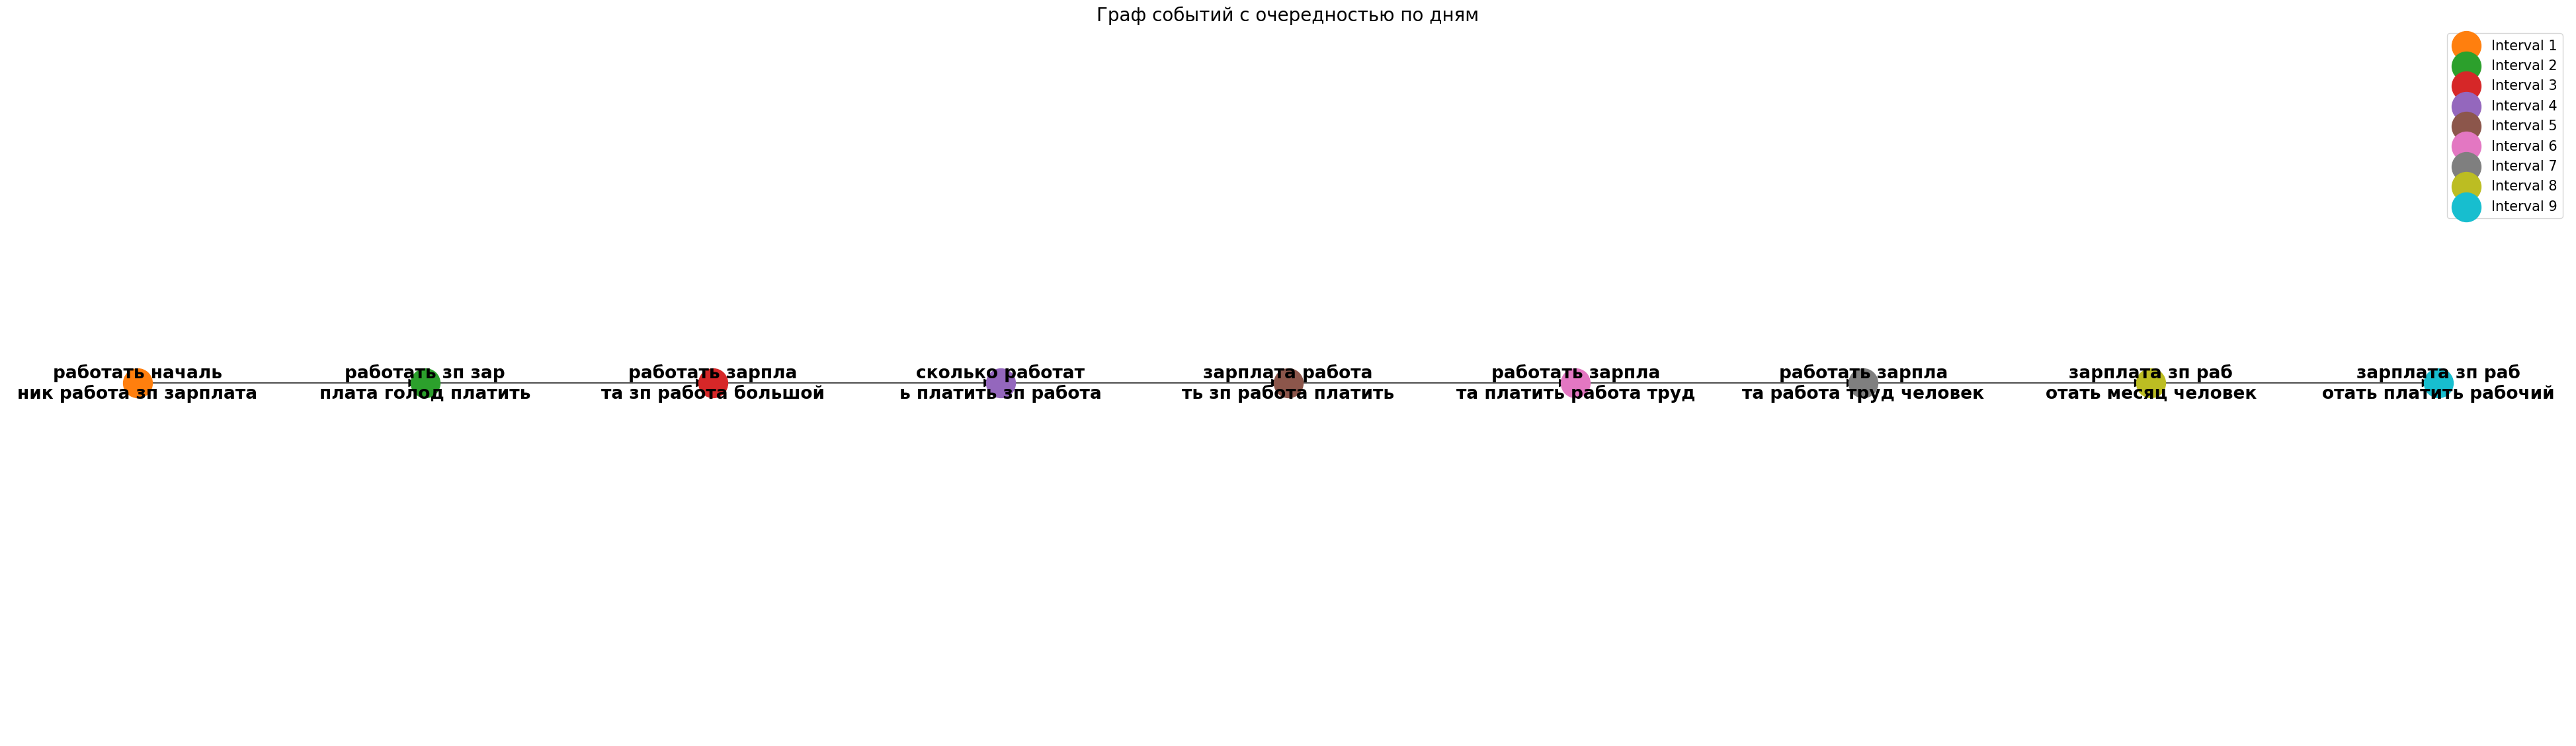

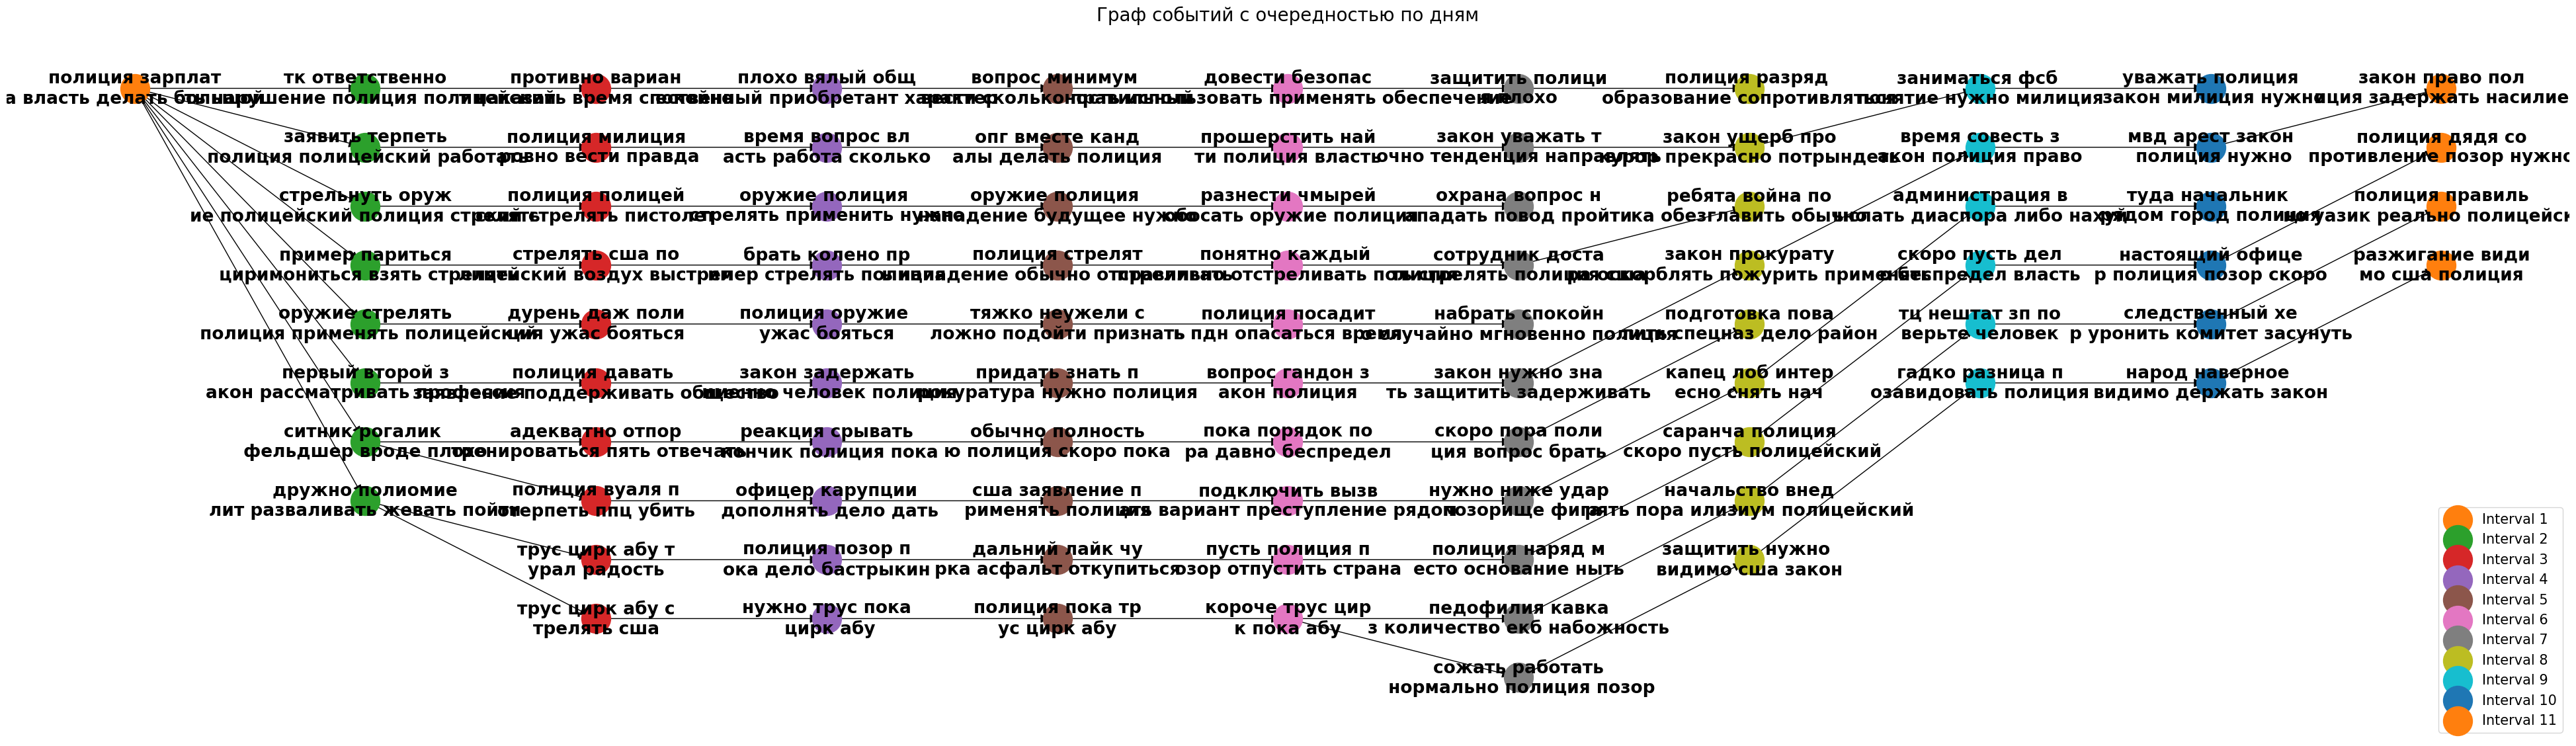

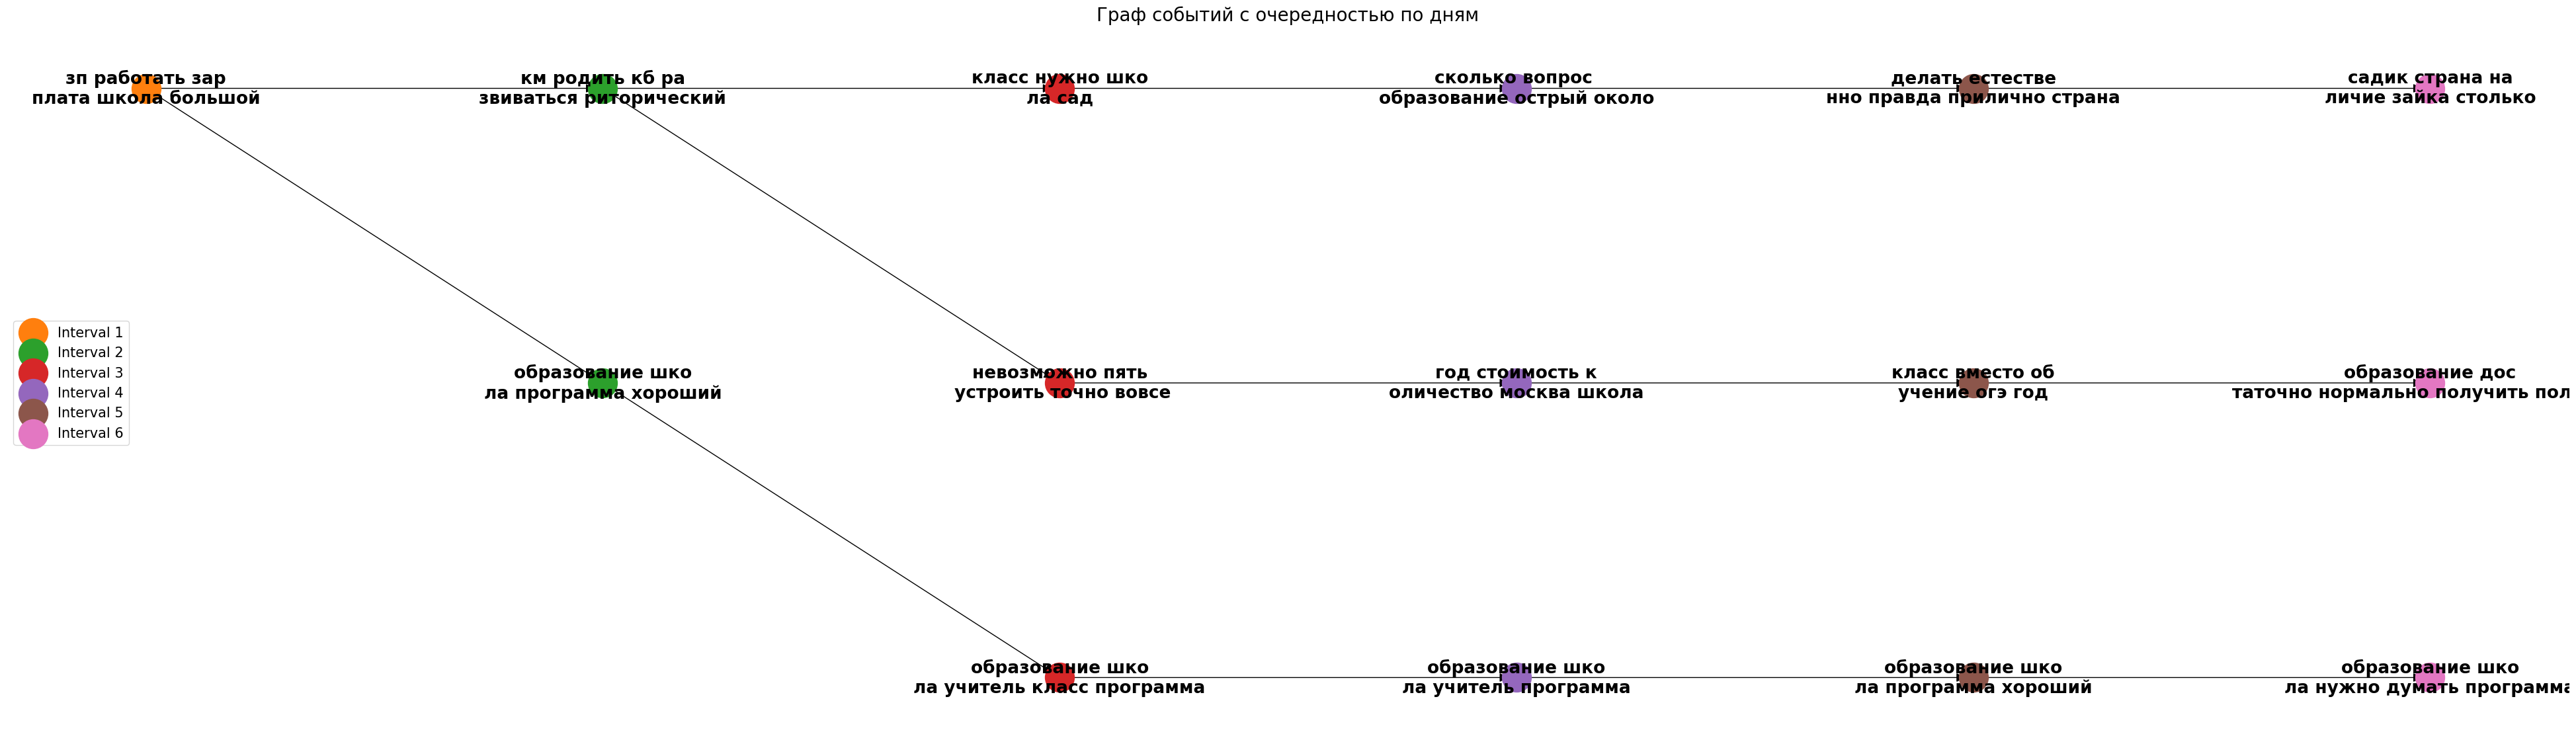

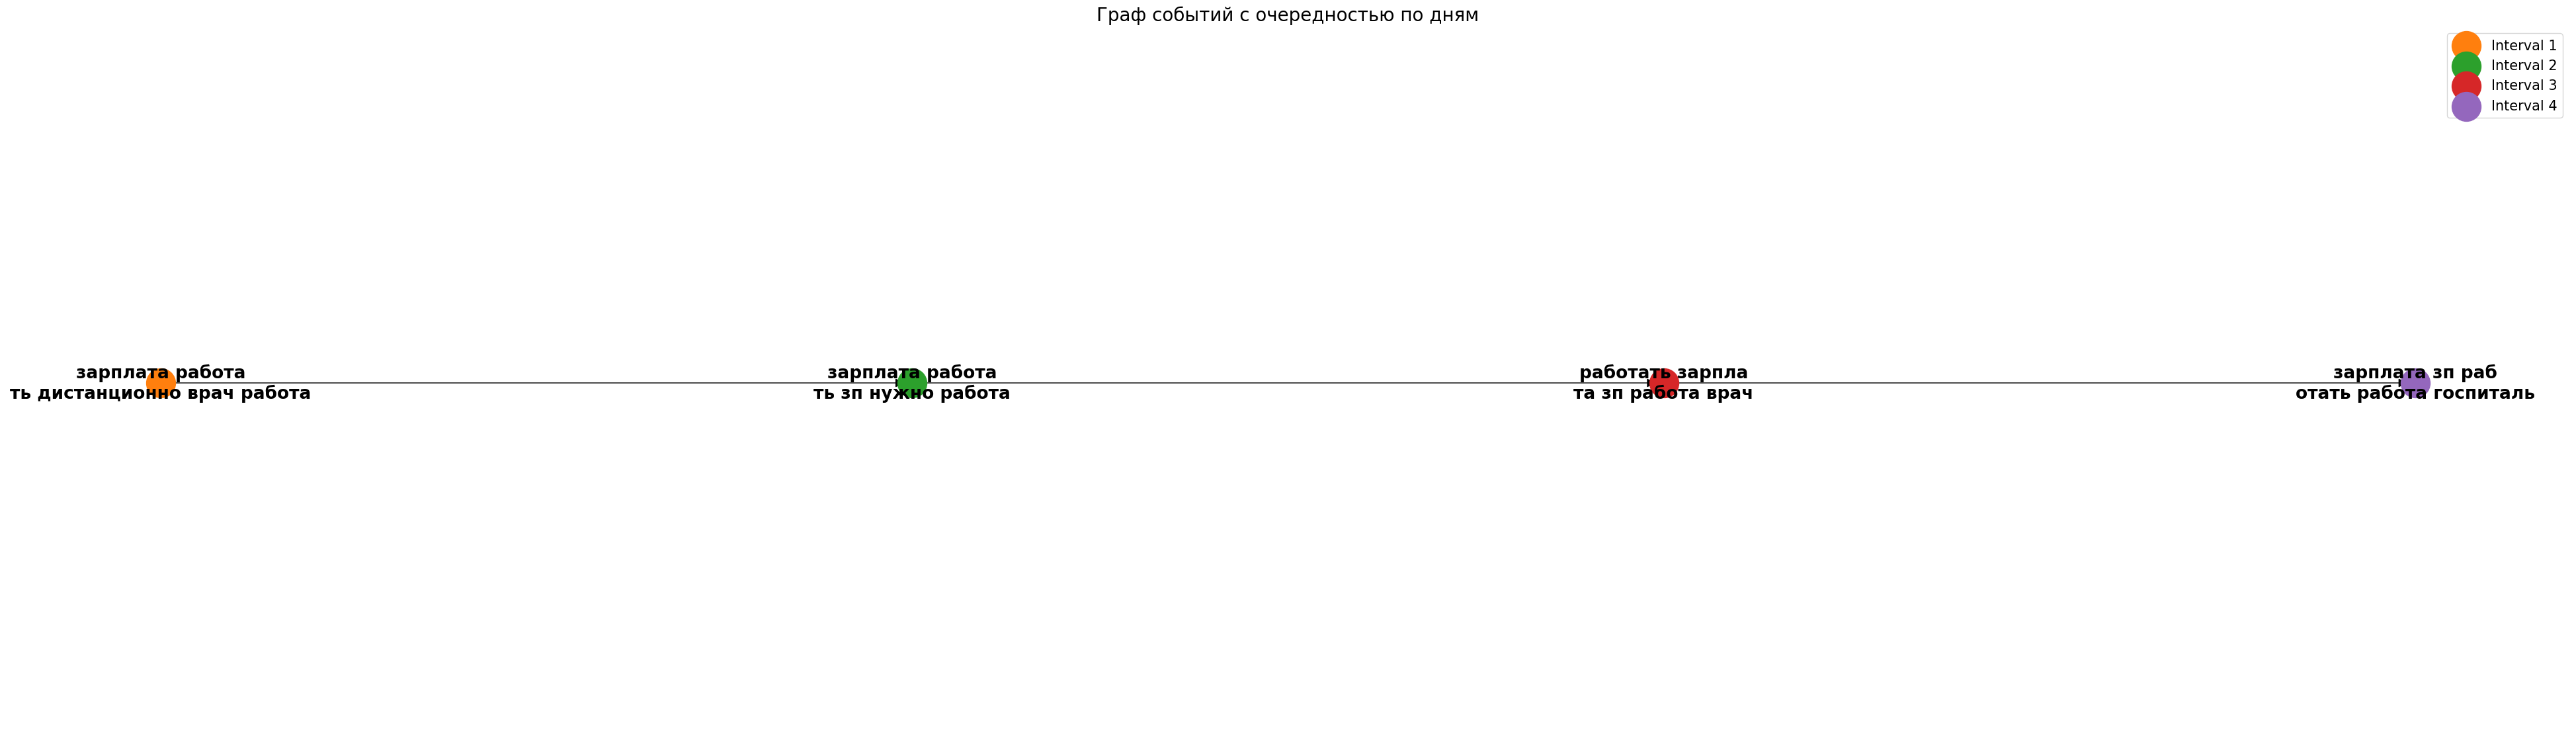

In [46]:
for topic in unique_topics:
    struct, days_to_nodes = global_graphs[topic]
    plot_graph(struct, days_to_nodes)

## Summarization

In [39]:
summary_by_topic = dict()

In [ ]:
# Параметры суммаризации
INTERVAL_MAX = 100
INTERVAL_MIN = 20
BRANCH_MAX   = 150
BRANCH_MIN   = 50
FINAL_MAX    = 300
FINAL_MIN    = 80
MODEL        = "telegram"


for topic in unique_topics:
    if topic in (0, 1, 3):
        continue
    print('Тема:', topic)
    struct, days_to_nodes = global_graphs[topic]
    
    # Берём единственный корень графа
    root = next(iter(struct))
    
    # Обход в глубину
    visited = set()
    stack = [root]
    all_branch_summaries = []
    
    while stack:
        branch = stack.pop()
        if branch in visited:
            continue
        visited.add(branch)
        
        # 1) Суммаризуем всю ветку (все интервалы подряд)
        summary = branch.summarize_all_intervals(
            max_length=BRANCH_MAX,
            min_length=BRANCH_MIN,
            model=MODEL
        )
        all_branch_summaries.append(summary)
        
        # 2) Добавляем детей в стек
        for child in struct.get(branch, []):
            stack.append(child)

    if len(all_branch_summaries) == 1: # если вся тема это одна ветка
        summary_by_topic[topic] = " ".join(all_branch_summaries)
        break

    combined = " ".join(all_branch_summaries)
    print('Общая суммаризация темы')
    topic_overview = summarize_text(
        combined,
        # max_tokens=FINAL_MAX,    # если через OpenAI API
        max_length=FINAL_MAX,    # если через HF-пайплайн
        min_length=FINAL_MIN,
        model=MODEL
    )

    summary_by_topic[topic] = topic_overview

In [42]:
for i, y in summary_by_topic.items():
    print(i)
    print(y)

0
Из обсуждения видно, что пользователи считают условия труда и уровень оплаты во многих сферах несправедливыми, что вызывает недовольство и демотивацию работников. Мнение людей разделилось: одни подчёркивают важность повышения зарплат и создания стабильных условий, другие отмечают проблемы с неэффективным управлением и бюрократией. Пользователи также считают, что кадровый дефицит связан прежде всего с низкой оплатой труда и призывают к справедливому распределению зарплат и реформам на рынке труда.
1
Из обсуждения видно, что пользователи считают полицию коррумпированной, бездействующей и неспособной эффективно защищать граждан, что вызывает недоверие и страх в обществе. Мнение людей сводится к критике правоохранительных органов за покрытие преступников, применение чрезмерной силы и недостаточную профессиональную подготовку, при этом из обсуждения видно разделение взглядов на необходимость реформ и ужесточения мер. Пользователи также считают, что полиция часто реагирует лишь под давлени